In [1]:
%load_ext autoreload
%autoreload 2

# Example1

This example models runoff quantity and quality in a small
hypothetical drainage area. It consists of 8 subcatchments
connected to a system of 1 to 2 foot diameter storm drains.
There are two pollutants (TSS and lead) and two land uses
(residential and undeveloped). Rainfall data for both a
short-term 36-hour period and a long-term 2 year period are
provided.

Here are some suggestions for running this example:

### 1. 
The model is set up to run in single event mode for a period of 36 hours using Kinematic Wave routing. Run the simulation.

In [ ]:
from swmm_api.output_file import OBJECTS, VARIABLES
from swmm_api.run_swmm import swmm5_run_epa, swmm5_run_progress
from swmm_api import SwmmInput, SwmmOutput, SwmmReport
from swmm_api.run_swmm.run_temporary import swmm5_run_temporary


In [2]:
inp = SwmmInput('Example1.inp')

In [3]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_epa, label='example_run_swmm') as res:
    out = res.out  # type: SwmmOutput
    rpt = res.rpt  # type: SwmmReport

### 2. View the Status Report for the run, noting the Continuity error.

In [4]:
rpt.get_simulation_info()

{'Analysis begun on': '  Mon Oct 28 18:19:39 2024',
 'Analysis ended on': '  Mon Oct 28 18:19:39 2024',
 'Total elapsed time': ' < 1 sec'}

In [5]:
rpt.available_parts

['Simulation Infos',
 'Version+Title',
 'Analysis Options',
 'Runoff Quantity Continuity',
 'Runoff Quality Continuity',
 'Flow Routing Continuity',
 'Quality Routing Continuity',
 'Highest Flow Instability Indexes',
 'Routing Time Step Summary',
 'Subcatchment Runoff Summary',
 'Subcatchment Washoff Summary',
 'Node Depth Summary',
 'Node Inflow Summary',
 'Node Flooding Summary',
 'Outfall Loading Summary',
 'Link Flow Summary',
 'Conduit Surcharge Summary',
 'Link Pollutant Load Summary']

In [6]:
rpt.print_raw_part('Runoff Quantity Continuity')
rpt.print_raw_part('Runoff Quality Continuity')

  **************************        Volume         Depth
  Runoff Quantity Continuity     acre-feet        inches
  **************************     ---------       -------
  Total Precipitation ......        15.679         2.650
  Evaporation Loss .........         0.000         0.000
  Infiltration Loss ........         9.649         1.631
  Surface Runoff ...........         5.991         1.013
  Final Storage ............         0.081         0.014
  Continuity Error (%) .....        -0.263
  **************************           TSS          Lead
  Runoff Quality Continuity            lbs           lbs
  **************************    ----------    ----------
  Initial Buildup ..........      3433.036         0.000
  Surface Buildup ..........       309.201         0.084
  Wet Deposition ...........         0.000         0.000
  Sweeping Removal .........         0.000         0.000
  Infiltration Loss ........         0.000         0.000
  BMP Removal ..............         0.000   


## 3. Select some different output variables (e.g. subcatchment runoff, node flooding, link flow) for viewing on the study area map. 

Use the Day/Time controls on the Map Browser to move back and forth through time.

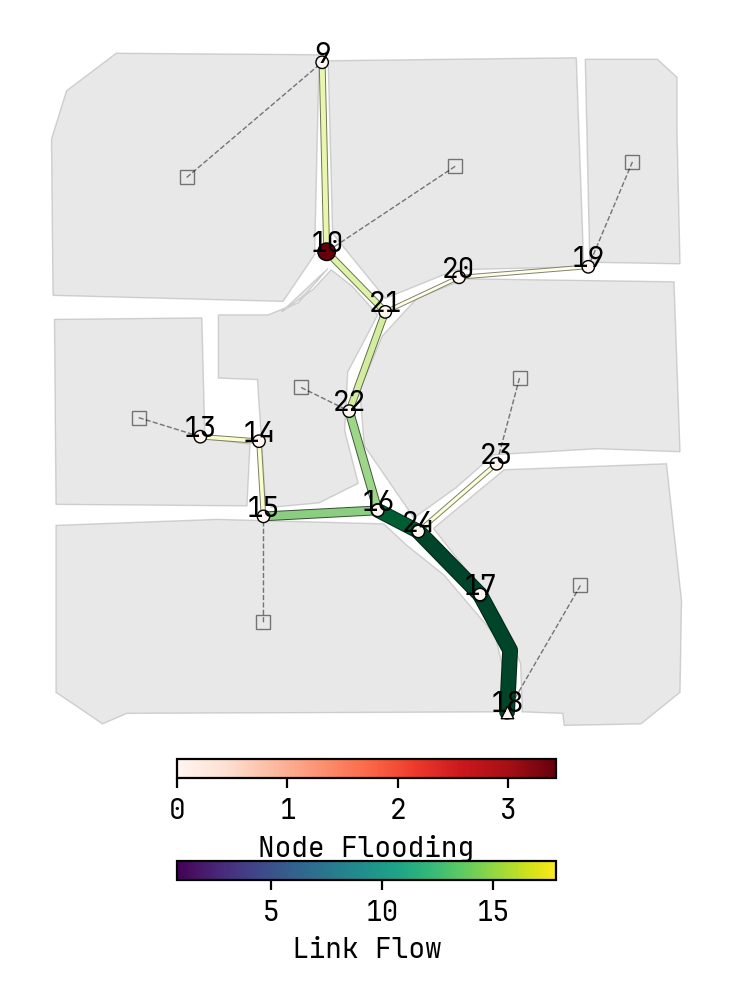

In [10]:
from swmm_api.input_file.macros.plotting_map import *

link_flow = out.get_part(OBJECTS.LINK, None, VARIABLES.LINK.FLOW)
node_flooding = out.get_part(OBJECTS.NODE, None, VARIABLES.NODE.FLOODING)

_, ax = init_empty_map_plot()
add_link_map(ax, inp, values_dict=link_flow.loc['1998-01-01 04:00'].to_dict(), make_width_proportional=True, cmap='YlGn', colorbar_kwargs={'label':'Link Flow'})
add_subcatchment_map(ax, inp)
add_node_map(ax, inp, make_size_proportional=True, cmap='Reds', values_dict=node_flooding.loc['1998-01-01 04:00'].to_dict(), colorbar_kwargs={'label':'Node Flooding'})
add_node_labels(ax, inp)


4. Try animating the map by using the Animator Toolbar (make the
   toolbar visible by selecting View | Toolbars | Animator from the
   Main Menu).

5. Try generating some other types of reports, such as a time series
   plot and a profile plot.

<Axes: >

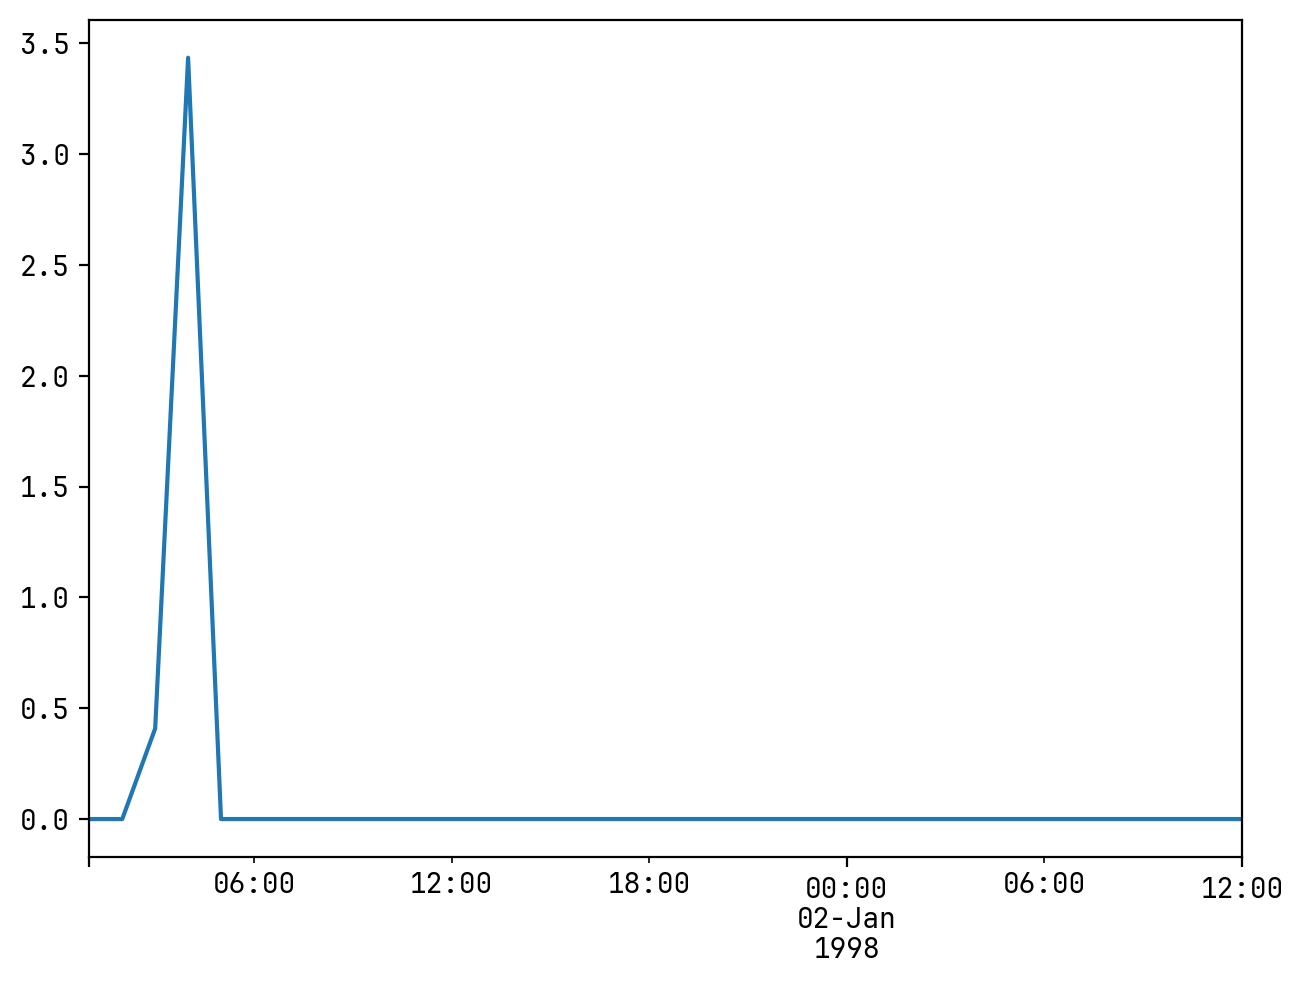

In [11]:
out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.FLOODING).plot()

(<Figure size 1280x960 with 1 Axes>, <Axes: >)

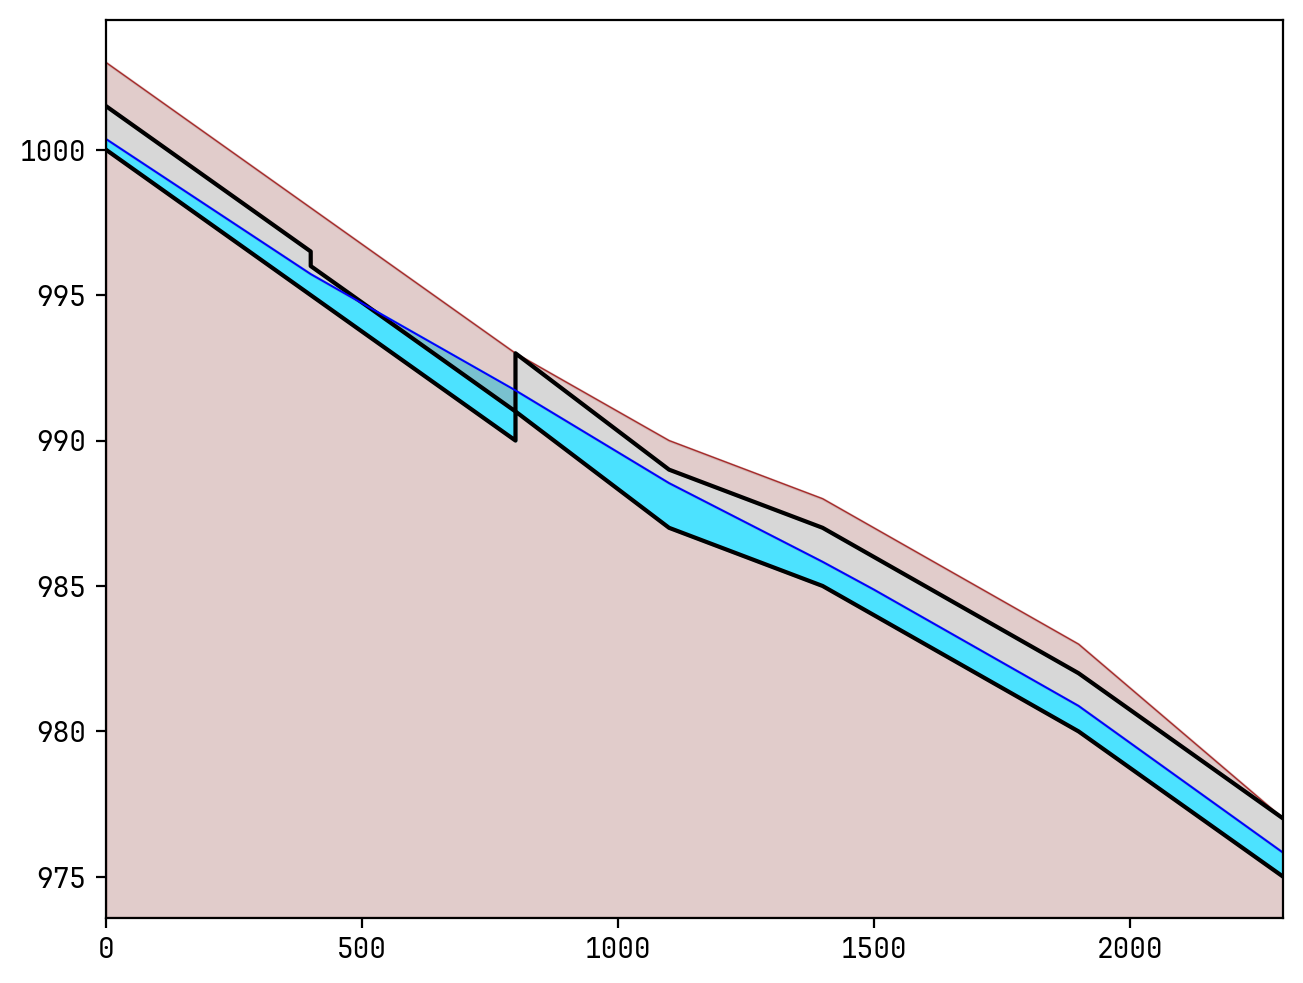

In [12]:
from swmm_api.input_file.macros.plotting_longitudinal import plot_longitudinal

plot_longitudinal(inp, '9', '18', out, depth_agg_func=lambda x: x.loc['1998-01-01 05:00'])

6. Change the Simulation Options to use Dynamic Wave routing and
   re-run the analysis. 

(<Figure size 1280x960 with 1 Axes>, <Axes: >)

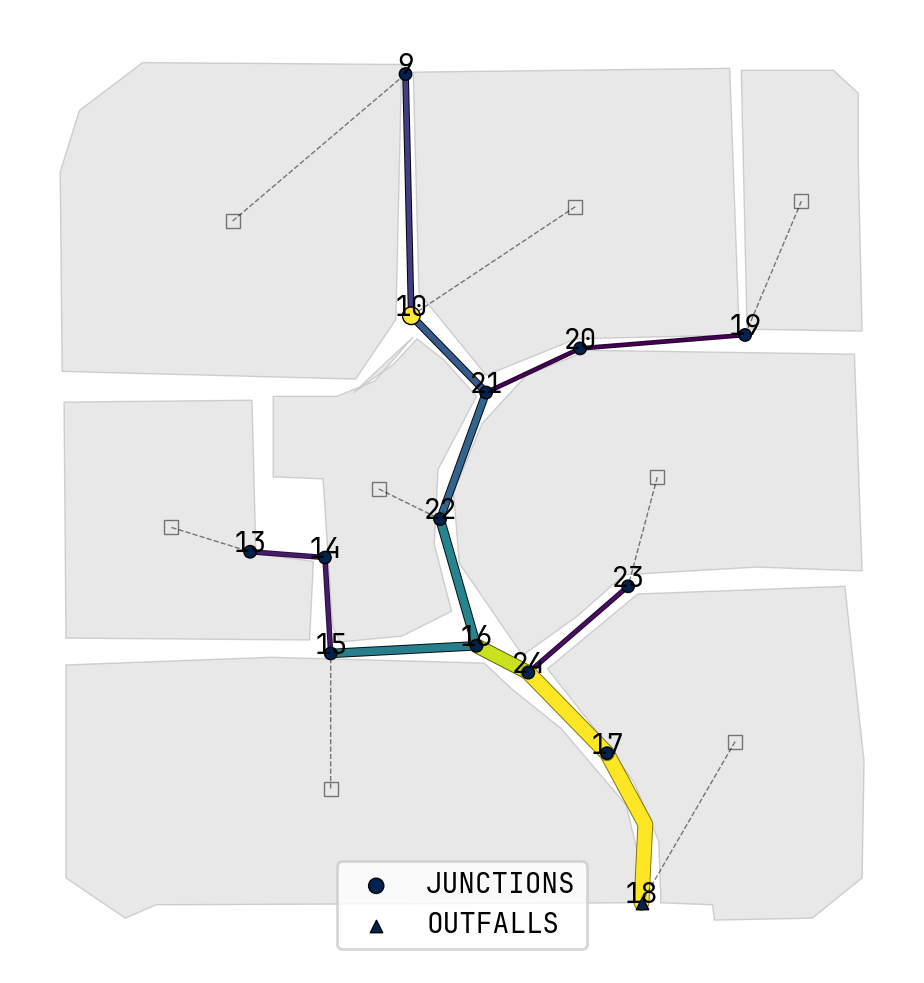

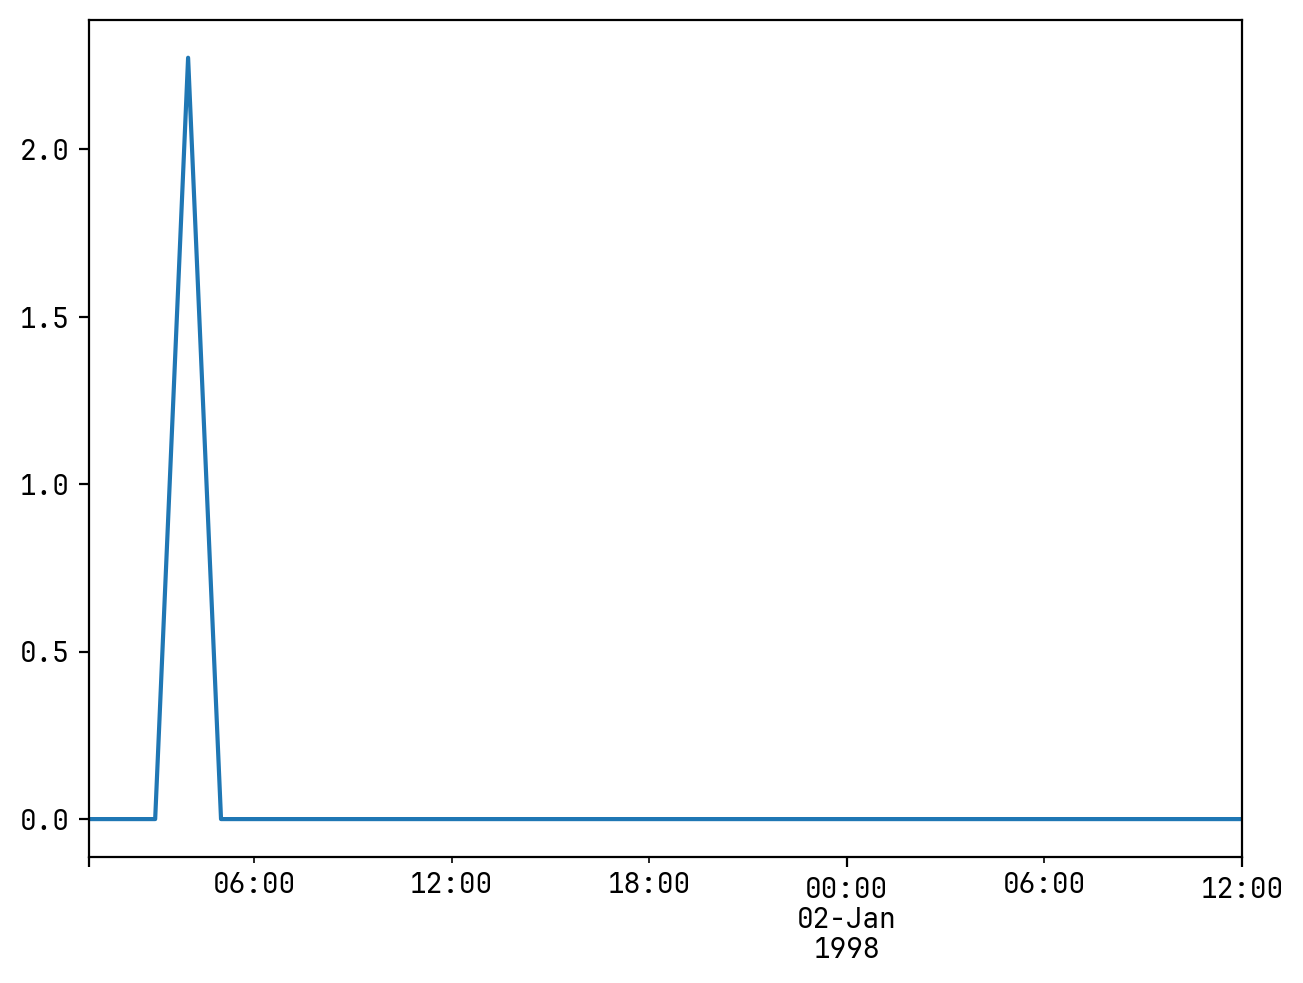

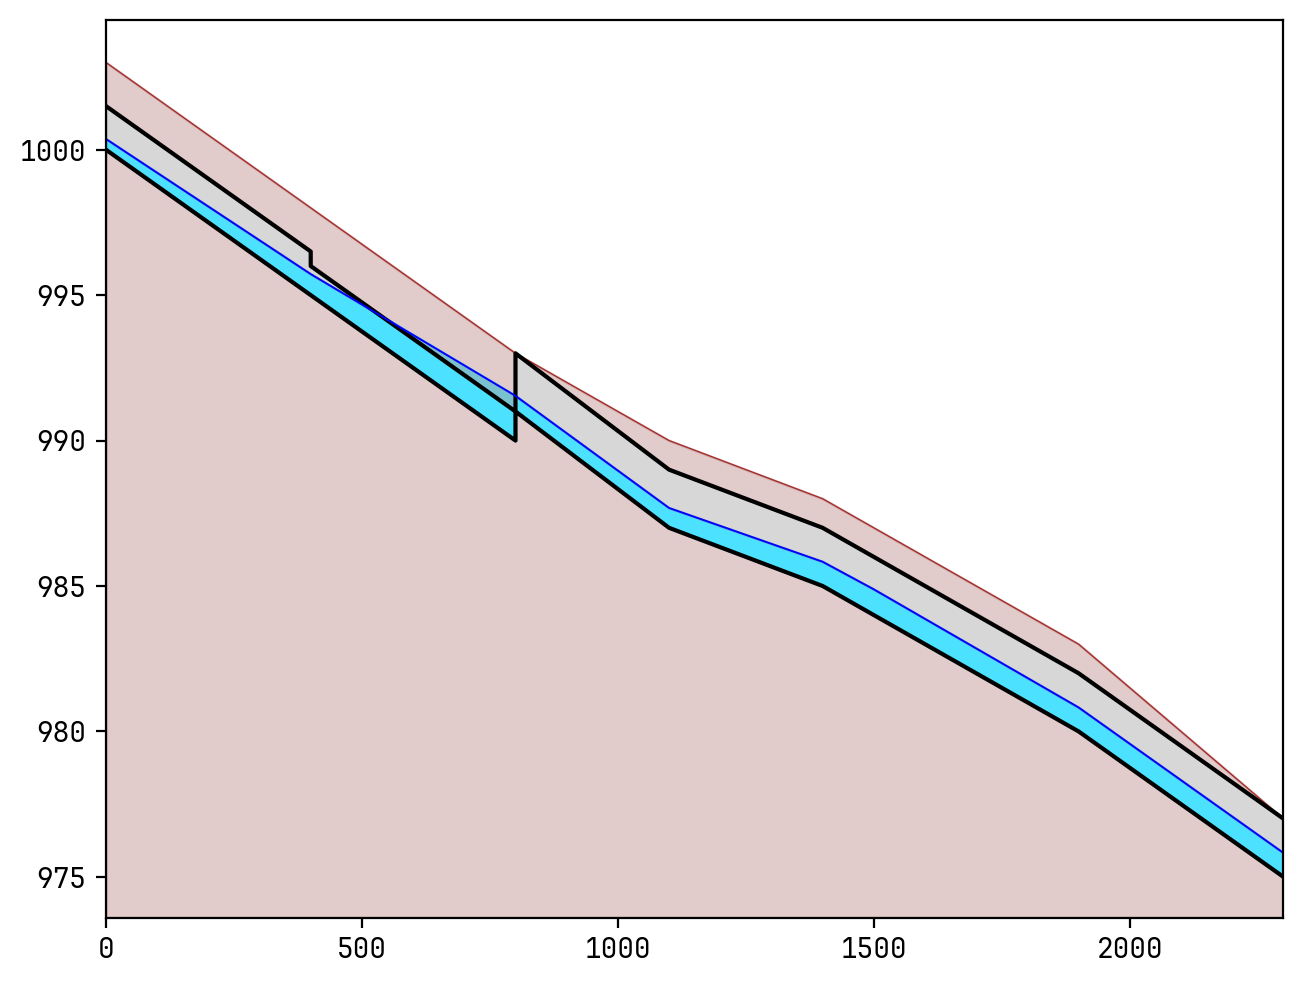

In [13]:
inp.OPTIONS['FLOW_ROUTING'] = 'DYNWAVE'
with swmm5_run_temporary(inp.copy(), run=swmm5_run_epa, label='example_run_swmm') as res:
    out = res.out  # type: SwmmOutput
    rpt = res.rpt  # type: SwmmReport

# ---
fig, ax = init_empty_map_plot()

link_flow = out.get_part(OBJECTS.LINK, None, VARIABLES.LINK.FLOW)
node_flooding = out.get_part(OBJECTS.NODE, None, VARIABLES.NODE.FLOODING)

add_link_map(ax, inp, values_dict=link_flow.loc['1998-01-01 04:00'].to_dict(), make_width_proportional=True, cmap='viridis')
add_subcatchment_map(ax, inp)
add_node_map(ax, inp, make_size_proportional=True, cmap='cividis', values_dict=node_flooding.loc['1998-01-01 04:00'].to_dict())
add_node_labels(ax, inp)

# ---
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.FLOODING).plot(ax=ax)

# ---
plot_longitudinal(inp, '9', '18', out, depth_agg_func=lambda x: x.loc['1998-01-01 05:00'])

7. Modify the model to run a continuous simulation as follows:
   
   1) Edit the rain gage and change its Data Source to File, click
      on the File Name field and specify the rain data file named 
      sta310301.dat, and enter 310301 for the Station Number.
   2) Edit the Simulation Options as follows:

      1. change the Routing Method back to Kinematic Wave
      2. make the End Date 01-02-2000 (for a 2-year simulation)
      3. change the Routing Time Step to 5 minutes.

In [14]:
inp.RAINGAGES

{   'RG1': RainGage(name='RG1', form='INTENSITY', interval='1:00', SCF=1.0, source='TIMESERIES', timeseries='TS1', filename=nan, station=nan, units=nan)}

In [15]:
import numpy as np

inp.RAINGAGES['RG1'].source = 'FILE'
inp.RAINGAGES['RG1'].timeseries = np.nan
inp.RAINGAGES['RG1'].filename = 'sta310301.dat'
inp.RAINGAGES['RG1'].station = '310301'
inp.RAINGAGES['RG1'].units = 'MM'

inp.OPTIONS['FLOW_ROUTING'] = 'KINWAVE'
inp.OPTIONS['END_DATE'] = '01/02/2000'
inp.OPTIONS['ROUTING_STEP'] = 300

8. Run the simulation (it may take several minutes). Try generating
   a Statistics Report to see how the magnitude of various kinds of
   events (rainfall, runoff, quality, etc.) are distributed over
   time.

In [16]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_progress, label='example_run_swmm') as res:
    rpt = res.rpt  # type: SwmmReport
    out = res.out  # type: SwmmOutput

swmm5 /var/folders/3v/lct6k8mn02xdl7r3zg30bjl00000gn/T/tmpv7xvn6tv/example_run_swmm.inp:   0%|          | 0/10…

In [17]:
rpt.print_raw_part('Runoff Quantity Continuity')
print('='*60)
rpt.print_raw_part('Runoff Quality Continuity')

  **************************        Volume         Depth
  Runoff Quantity Continuity     acre-feet        inches
  **************************     ---------       -------
  Total Precipitation ......       389.139        65.770
  Evaporation Loss .........         0.000         0.000
  Infiltration Loss ........       251.353        42.482
  Surface Runoff ...........       138.720        23.446
  Final Storage ............         0.078         0.013
  Continuity Error (%) .....        -0.260
  **************************           TSS          Lead
  Runoff Quality Continuity            lbs           lbs
  **************************    ----------    ----------
  Initial Buildup ..........      3433.036         0.000
  Surface Buildup ..........     17992.499         3.311
  Wet Deposition ...........         0.000         0.000
  Sweeping Removal .........         0.000         0.000
  Infiltration Loss ........         0.000         0.000
  BMP Removal ..............         0.000   

In [18]:
out.index.freq

<Hour>

In [19]:
out.flow_unit

'CFS'

In [20]:
from swmm_api.output_file.analysis import get_event_table, agg_events
import pandas as pd

p = out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.RAINFALL)  # unit is in/hr

events = get_event_table(p>0, delta_separation=pd.Timedelta(hours=6))
events['total rainfall'] = agg_events(events, p, 'sum') # only sums values - units must be checks and converted accordingly
events['peak rainfall'] = agg_events(events, p, 'max')
events

start                 end        duration  total rainfall  \
0   1998-01-06 04:00:00 1998-01-06 05:00:00 0 days 01:00:00            0.02   
1   1998-01-07 03:00:00 1998-01-08 02:00:00 0 days 23:00:00            3.35   
2   1998-01-11 17:00:00 1998-01-11 18:00:00 0 days 01:00:00            0.02   
3   1998-01-14 23:00:00 1998-01-15 17:00:00 0 days 18:00:00            0.94   
4   1998-01-16 08:00:00 1998-01-16 13:00:00 0 days 05:00:00            0.58   
..                  ...                 ...             ...             ...   
208 1999-12-06 16:00:00 1999-12-06 16:00:00 0 days 00:00:00            0.01   
209 1999-12-10 06:00:00 1999-12-10 07:00:00 0 days 01:00:00            0.18   
210 1999-12-12 23:00:00 1999-12-13 11:00:00 0 days 12:00:00            0.66   
211 1999-12-21 05:00:00 1999-12-21 07:00:00 0 days 02:00:00            0.13   
212 1999-12-21 14:00:00 1999-12-21 15:00:00 0 days 01:00:00            0.06   

     peak rainfall  
0             0.01  
1             0.50  
2             0.01  
3             0.10  
4             0.28  
..             ...  
208           0.01  
209           0.10  
210           0.20  
211           0.07  
212           0.04  

[213 rows x 5 columns]

In [21]:
p.resample('D').sum().sort_values(ascending=False)

1998-01-07    3.10
1998-04-19    1.83
1998-01-27    1.82
1999-11-25    1.71
1999-01-02    1.61
              ... 
1998-10-25    0.00
1998-10-26    0.00
1998-10-27    0.00
1998-10-28    0.00
2000-01-02    0.00
Name: system//rainfall, Length: 732, dtype: float64